In [11]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization

import tensorflow as tf # Deep Learning
import tensorflow_hub as hub
 

In [12]:
df = pd.read_csv('wine-reviews.csv', usecols = ['country', 'description', 'points', 'price' , 'variety', 'winery']) # Read the data only with the columns that we need
df.head() # Show the first 5 rows of the data

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [13]:
df = df.dropna(subset = ["description", "points"]) # Drop the rows with missing values

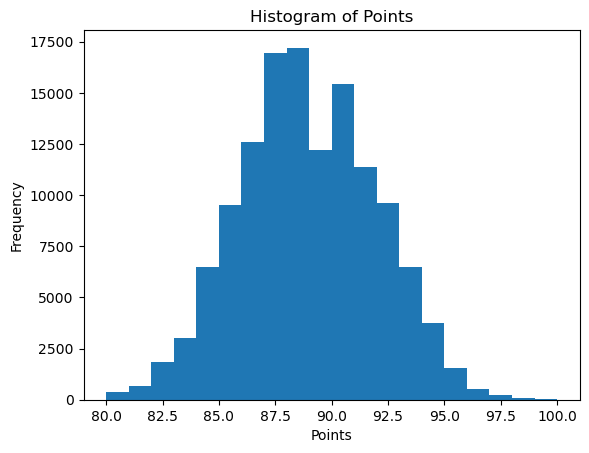

In [14]:
plt.hist(df.points, bins = 20) # Plot the histogram of the points
plt.title("Histogram of Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [17]:
df["label"] = df["points"].apply(lambda x: 1 if x >= 90 else 0) # Create a new column with the label 1 if the points are greater than or equal to 90 and 0 otherwise
df = df[["description", "label"]] # Keep only the description and the label columns because we will use binary classification

In [18]:
df.head() # Show the first 5 rows of the data

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [19]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data respectively

In [20]:
len(train), len(val), len(test) # Show the length of the train, validation and test sets

(103976, 12997, 12998)

In [32]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
  df = dataframe.copy() # avoid modifying the original dataframe
  labels = df.pop("label") # Remove the label column from the dataframe
  df = df["description"] # Keep only the description column
  ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
  if shuffle: # Shuffle the dataset if needed
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)  # Batch the dataset
  ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
  return ds

In [33]:
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

In [34]:
embedding = "https://www.kaggle.com/models/google/nnlm/frameworks/tensorFlow2/variations/en-dim50/versions/1" # Load the embedding model
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True) # Create a keras layer with the embedding model

In [35]:
hub_layer(list(train_data)[0][0]) # Show the output of the embedding layer for the first batch of the train data

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.3661005 , -0.04464634,  0.00561695, ..., -0.11749372,
        -0.2354176 ,  0.10122002],
       [ 0.3854938 , -0.48512292, -0.24963953, ...,  0.10279011,
        -0.27244538, -0.15052125],
       [ 0.24046785, -0.24074158,  0.14304811, ...,  0.19854642,
        -0.11351566,  0.0336073 ],
       ...,
       [ 0.41055018, -0.03383618,  0.00493392, ..., -0.1228281 ,
        -0.1860729 ,  0.01930945],
       [ 0.26823324, -0.05206691,  0.17935418, ..., -0.1371465 ,
        -0.2682591 , -0.17126672],
       [ 0.36976773, -0.20759118,  0.20550525, ..., -0.01169562,
        -0.15375045,  0.1673407 ]], dtype=float32)>

In [62]:
model = tf.keras.Sequential() # Create a sequential model
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.4)) # Add a dropout layer to avoid overfitting
model.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.4)) # Add a dropout layer to avoid overfitting
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [63]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.BinaryCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [64]:
model.evaluate(train_data) # Evaluate the model on the test data

102/102 [==============================] - 2s 22ms/step - loss: 1.0984 - accuracy: 0.5365


[1.0983917713165283, 0.5364795923233032]

In [65]:
model.evaluate(val_data) # Evaluate the model on the validation data

13/13 [==============================] - 0s 22ms/step - loss: 1.1003 - accuracy: 0.5217


[1.1003040075302124, 0.5217357873916626]

In [66]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
102/102 [==============================] - 17s 159ms/step - loss: 0.8517 - accuracy: 0.7257 - val_loss: 0.6404 - val_accuracy: 0.8239
Epoch 2/5
102/102 [==============================] - 16s 157ms/step - loss: 0.5578 - accuracy: 0.8438 - val_loss: 0.5142 - val_accuracy: 0.8280
Epoch 3/5
102/102 [==============================] - 16s 156ms/step - loss: 0.4465 - accuracy: 0.8651 - val_loss: 0.4639 - val_accuracy: 0.8284
Epoch 4/5
102/102 [==============================] - 16s 157ms/step - loss: 0.3963 - accuracy: 0.8743 - val_loss: 0.4457 - val_accuracy: 0.8290
Epoch 5/5
102/102 [==============================] - 16s 157ms/step - loss: 0.3686 - accuracy: 0.8798 - val_loss: 0.4390 - val_accuracy: 0.8291


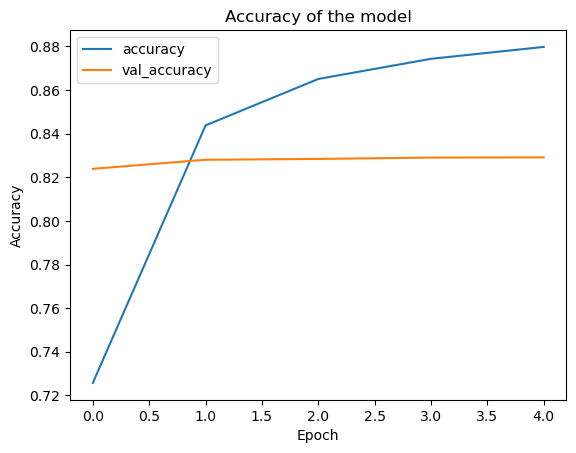

In [67]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

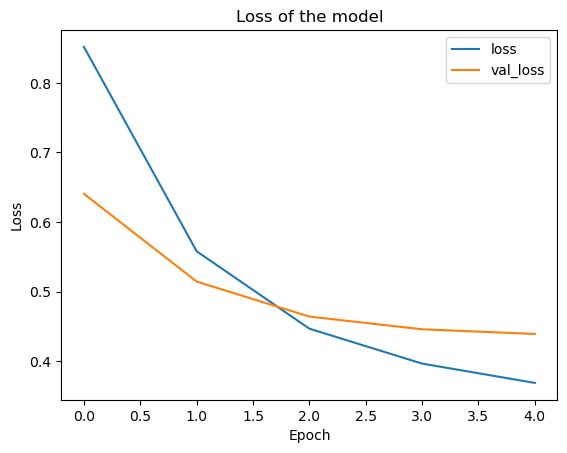

In [68]:
plt.plot(history.history['loss'], label='loss') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_loss'], label = 'val_loss') # Plot the accuracy of the model on the validation data
plt.title('Loss of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
model.evaluate(test_data) # Evaluate the model on the test data

13/13 [==============================] - 0s 21ms/step - loss: 0.4463 - accuracy: 0.8271


[0.44632744789123535, 0.8271272778511047]

In [70]:
# LSTM MODEL
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [71]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [73]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [74]:
model2.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.BinaryCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [75]:
model2.evaluate(train_data) # Evaluate the model on the test data

102/102 [==============================] - 10s 94ms/step - loss: 0.6932 - accuracy: 0.4913


[0.6931723356246948, 0.4913153052330017]

In [76]:
model2.evaluate(val_data) # Evaluate the model on the validation data

13/13 [==============================] - 1s 88ms/step - loss: 0.6932 - accuracy: 0.4887


[0.693193793296814, 0.48865121603012085]

In [77]:
model2.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
102/102 [==============================] - 28s 259ms/step - loss: 0.5449 - accuracy: 0.7138 - val_loss: 0.3867 - val_accuracy: 0.8178
Epoch 2/5
102/102 [==============================] - 28s 277ms/step - loss: 0.3704 - accuracy: 0.8358 - val_loss: 0.3588 - val_accuracy: 0.8327
Epoch 3/5
102/102 [==============================] - 28s 277ms/step - loss: 0.3527 - accuracy: 0.8432 - val_loss: 0.3592 - val_accuracy: 0.8343
Epoch 4/5
102/102 [==============================] - 30s 290ms/step - loss: 0.3421 - accuracy: 0.8487 - val_loss: 0.3540 - val_accuracy: 0.8347
Epoch 5/5
102/102 [==============================] - 29s 281ms/step - loss: 0.3379 - accuracy: 0.8497 - val_loss: 0.3516 - val_accuracy: 0.8363


In [78]:
model2.evaluate(test_data) # Evaluate the model on the test data

13/13 [==============================] - 1s 96ms/step - loss: 0.3483 - accuracy: 0.8402


[0.34826648235321045, 0.8402062058448792]